<a href="https://colab.research.google.com/github/Pj-354/FICC-Coursework/blob/main/Q11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[[100.         100.08431105 100.0608236  ...  97.70461347  97.7317326
   97.97449144]
 [100.         100.16488516  99.94468676 ... 112.89759236 113.01898569
  113.05131117]
 [100.         100.0204279  100.14274022 ...  95.01754072  94.92065068
   94.89931459]]
[[   0.            0.            0.         ... -100.
  -100.         -101.63330291]
 [   0.            0.            0.         ...  -87.94596692
   -87.94596692  -89.8306109 ]
 [   0.            0.            0.         ...   -5.06674852
    -5.06674852   -6.64878609]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0.         0.         0.         ... 0.         0.         0.76512108]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]
[[-0.45147334 -0.45147334 -0.45147334 ...  0.25907599  0.25907599
   1.02419707]
 [-0.45147334 -0.45147334 -0.45147334 ...  1.02419707  1.02419707
   1.02419707]
 [-0.4514

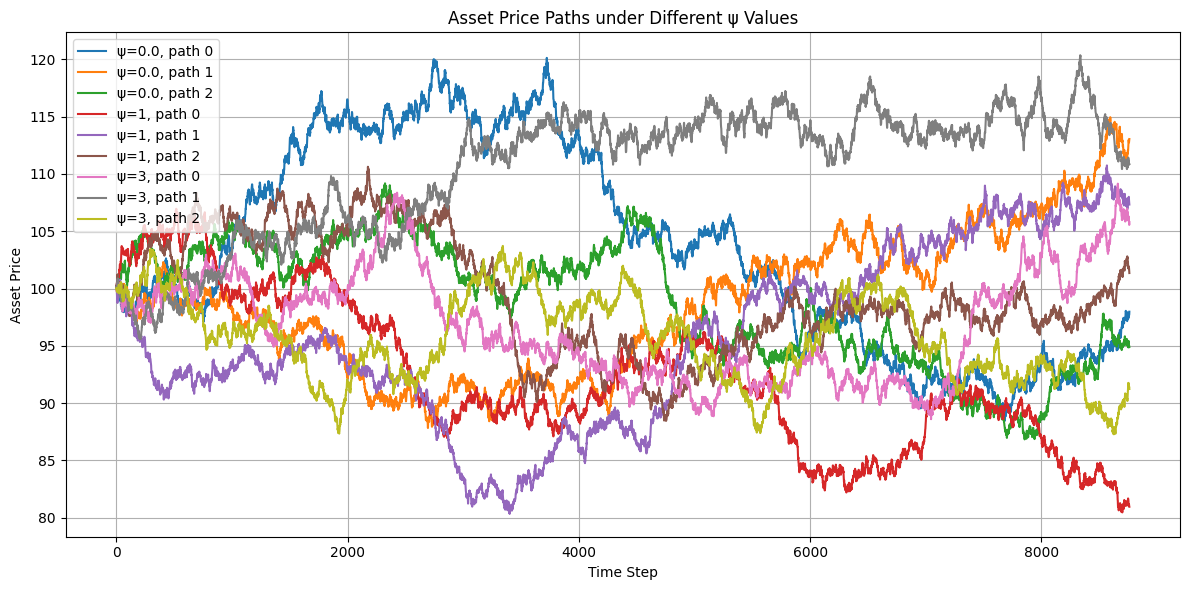

    time  path           S       delta         cash  portfolio_value
0      0     0  100.000000 -381.723809     0.000000    -38172.380875
1      0     1  100.000000 -381.723809     0.000000    -38172.380875
2      0     2  100.000000 -381.723809     0.000000    -38172.380875
3   2190     0  113.709361    1.024197  3831.092395      3947.553189
4   2190     1   90.358560    1.024197   148.800382       241.345355
5   2190     2  104.578787    1.024197    -1.743401       105.365886
6   4380     0  105.999953    1.024197  3829.325302      3937.890143
7   4380     1   92.984791    1.024197   147.250261       242.485011
8   4380     2  104.257114    1.024197    -3.481440       103.298391
9   6570     0   95.132624    1.024197  4764.411745      4861.846300
10  6570     1  104.025163    1.024197  1659.701737      1766.244004
11  6570     2   95.095542    1.024197    -5.066749        92.329827
12  8760     0   97.974491    1.024197  4762.778442      4863.123629
13  8760     1  113.051311    1.02

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import norm

# Simulation parameters
r = 0
mu = 0
S0 = 100
B0 = 1
sigma = 0.2
theta_0 = 1
b_0 = 0
b = -100
psi = 3  # change for comparison
dt = 1 / (365 * 24 * 1)  # hourly
beta = 0.28
alpha = 0.5
phi = 1
gamma = 0.2
zeta = 0.05
w0 = 10
T = 1  # total time in years
N = int(T / dt)
M = 3  # number of paths
quarter_len = int(0.25 / dt)  # 每季度步数
opex_indices = [0, quarter_len, 2 * quarter_len, 3 * quarter_len, N]

np.random.seed(42)

def bs_price(S, K, T, sigma, r=0, option_type='call'):
    if T <= 0 or sigma <= 0 or S <= 0 or K <= 0:
        return 0.0
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    if option_type == 'call':
        return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    else:
        return K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)

def bs_delta(S, K, T, sigma, option_type='call', r=0):
    if T <= 0 or sigma <= 0 or S <= 0 or K <= 0:
        return 0.0
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    if option_type == 'call':
        return norm.cdf(d1)
    else:
        return norm.cdf(d1) - 1

def simulate_full_paths(S0, b_0, sigma, psi, zeta, phi, theta_0, b,
                        dt, N, M, opex_indices, asset_type='NVDA'):

    S = np.zeros((M, N + 1))
    b_t_I = np.zeros((M, N + 1))
    dDelta = np.zeros((M, N))
    M_t = np.zeros((M, N))
    delta_t = np.zeros((M, N + 1))

    K_call = np.zeros((M, len(opex_indices)))
    K_put = np.zeros((M, len(opex_indices)))

    S[:, 0] = S0
    b_t_I[:, 0] = b_0

    for path in range(M):
        for t in range(N + 1):
            if t == 0:
                T_remain = 0.25
                K_call[path, 0] = S0 * np.exp(sigma * np.sqrt(T_remain))
                K_put[path, 0] = S0 * np.exp(-sigma * np.sqrt(T_remain))
                put_price = bs_price(S=S0, K=K_put[path, 0], T=T_remain, sigma=sigma, option_type='put')
                call_price = bs_price(S=S0, K=K_call[path, 0], T=T_remain, sigma=sigma, option_type='call')
                delta_call = bs_delta(S0, K_call[path, 0], T_remain, sigma, 'call')
                delta_put = bs_delta(S0, K_put[path, 0], T_remain, sigma, 'put')
                theta = (b_0 - theta_0 * S0) / (put_price + call_price)
                theta_t = theta
                prev_delta = theta_0*1 + theta * (delta_put + delta_call)

            S_t = S[path, t - 1] if t > 0 else S0

            if t > 0:
                last_opex_t = max([i for i in opex_indices if i < t])  # 找 OE(t)
                u_range = np.arange(last_opex_t, t)
                exponent = np.exp(-phi * dt * (t - 1 - u_range))
                M_t[path, t - 1] = np.sum(exponent * dDelta[path, last_opex_t:t])

                dW = np.random.normal(0, np.sqrt(dt))
                S_t_safe = max(S_t, 1e-6)
                M_cap = np.clip(M_t[path, t - 1], -1e6, 1e6)
                feedback = psi * S_t * M_t[path, t - 1] * dt
                diffusion = sigma * S_t**(1 - zeta) * dW

                total_change = S_t + feedback + diffusion
                S[path, t] = max(min(total_change, 1e6), 1e-6)
                S_t = S[path, t]

            if t in opex_indices and t != 0:
                idx = opex_indices.index(t)
                call_payoff = theta_t * max(S_t - K_call[path, idx - 1], 0)
                put_payoff = theta_t * max(K_put[path, idx - 1] - S_t, 0)
                b_t = b_t_I[path, t - 1] + call_payoff + put_payoff

                T_remain = 0.25
                K_call[path, idx] = S_t * np.exp(sigma * np.sqrt(T_remain))
                K_put[path, idx] = S_t * np.exp(-sigma * np.sqrt(T_remain))

                delta_call = bs_delta(S_t, K_call[path, idx], T_remain, sigma, 'call')
                delta_put = bs_delta(S_t, K_put[path, idx], T_remain, sigma, 'put')
                call_price = bs_price(S=S_t, K=K_call[path, idx], T=T_remain, sigma=sigma, option_type='call')
                put_price = bs_price(S=S_t, K=K_put[path, idx], T=T_remain, sigma=sigma, option_type='put')

                if b_t - b >= theta_0 * (put_price - call_price):
                    dDelta[path, t - 1] = theta_0 * (1+delta_put + delta_call) - prev_delta
                    prev_delta = theta_0 * (1+ delta_put + delta_call)
                    b_t_I[path, t] = b_t - theta_0 * (put_price + call_price)
                else:
                    theta = (b_t - b) / (put_price + call_price)
                    dDelta[path, t - 1] = theta_0 *1 + theta * (delta_put + delta_call) - prev_delta
                    prev_delta = theta_0 *1+ theta * (delta_put + delta_call)
                    b_t_I[path, t] = b_t - theta * (put_price + call_price)
            elif t > 0:
                b_t_I[path, t] = b_t_I[path, t - 1]

            delta_t[path, t] = prev_delta

    return S, b_t_I, M_t, dDelta, delta_t

S_NVDA, b_NVDA, M_NVDA, dDelta_NVDA, delta_NVDA = simulate_full_paths(
    S0, b_0, sigma, psi, zeta, phi, theta_0, b, dt, N, M, opex_indices, asset_type='NVDA')



# 打印输出
for i in [S_NVDA, b_NVDA, M_NVDA, dDelta_NVDA, delta_NVDA]:
    print(i)
def compare_psi_paths(psi_vals, seed=42):
    np.random.seed(seed)
    plt.figure(figsize=(12, 6))
    for psi_val in psi_vals:
        S_tmp, *_ = simulate_full_paths(
            S0, b_0, sigma, psi_val, zeta, phi, theta_0, b, dt, N, M, opex_indices
        )
        for path in range(M):
            plt.plot(S_tmp[path], label=f'ψ={psi_val}, path {path}')
    plt.title('Asset Price Paths under Different ψ Values')
    plt.xlabel('Time Step')
    plt.ylabel('Asset Price')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

compare_psi_paths(psi_vals=[0.0, 1, 3])


def simulate_full_paths(S0, b_0, sigma, psi, zeta, phi, theta_0, b,
                        dt, N, M, opex_indices, asset_type='NVDA', seed=42):
    np.random.seed(seed)
    S = np.zeros((M, N + 1))
    b_t_I = np.zeros((M, N + 1))
    dDelta = np.zeros((M, N))
    M_t = np.zeros((M, N))
    delta_t = np.zeros((M, N + 1))
    portfolio_value = np.zeros((M, N + 1))

    K_call = np.zeros((M, len(opex_indices)))
    K_put = np.zeros((M, len(opex_indices)))

    S[:, 0] = S0
    b_t_I[:, 0] = b_0

    for path in range(M):
        for t in range(N + 1):
            if t == 0:
                T_remain = 0.25
                K_call[path, 0] = S0 * np.exp(sigma * np.sqrt(T_remain))
                K_put[path, 0] = S0 * np.exp(-sigma * np.sqrt(T_remain))
                put_price = bs_price(S=S0, K=K_put[path, 0], T=T_remain, sigma=sigma, option_type='put')
                call_price = bs_price(S=S0, K=K_call[path, 0], T=T_remain, sigma=sigma, option_type='call')
                delta_call = bs_delta(S0, K_call[path, 0], T_remain, sigma, 'call')
                delta_put = bs_delta(S0, K_put[path, 0], T_remain, sigma, 'put')
                theta = (b_0 - theta_0 * S0) / (put_price - call_price)
                theta_t = theta
                prev_delta = theta * (delta_put - delta_call)

            S_t = S[path, t - 1] if t > 0 else S0

            if t > 0:
                last_opex_t = max([i for i in opex_indices if i < t])
                u_range = np.arange(last_opex_t, t)
                exponent = np.exp(-phi * dt * (t - 1 - u_range))
                M_t[path, t - 1] = np.sum(exponent * dDelta[path, last_opex_t:t])

                dW = np.random.normal(0, np.sqrt(dt))
                S_t_safe = max(S_t, 1e-6)
                feedback = psi * S_t * M_t[path, t - 1] * dt
                diffusion = sigma * S_t**(1 - zeta) * dW

                total_change = S_t + feedback + diffusion
                S[path, t] = max(min(total_change, 1e6), 1e-6)
                S_t = S[path, t]

            if t in opex_indices and t != 0:
                idx = opex_indices.index(t)
                call_payoff = theta_t * max(S_t - K_call[path, idx - 1], 0)
                put_payoff = theta_t * max(K_put[path, idx - 1] - S_t, 0)
                b_t = b_t_I[path, t - 1] + call_payoff + put_payoff

                T_remain = 0.25
                K_call[path, idx] = S_t * np.exp(sigma * np.sqrt(T_remain))
                K_put[path, idx] = S_t * np.exp(-sigma * np.sqrt(T_remain))

                delta_call = bs_delta(S_t, K_call[path, idx], T_remain, sigma, 'call')
                delta_put = bs_delta(S_t, K_put[path, idx], T_remain, sigma, 'put')
                call_price = bs_price(S=S_t, K=K_call[path, idx], T=T_remain, sigma=sigma, option_type='call')
                put_price = bs_price(S=S_t, K=K_put[path, idx], T=T_remain, sigma=sigma, option_type='put')

                if b_t - b >= theta_0 * (put_price + call_price):
                    dDelta[path, t - 1] = theta_0 * (1+ delta_put + delta_call) - prev_delta
                    prev_delta = theta_0 * (1+ delta_put + delta_call)
                    b_t_I[path, t] = b_t - theta_0 * (put_price + call_price)
                else:
                    theta = (b_t - b) / (put_price - call_price)
                    dDelta[path, t - 1] = theta_0*1 + theta * (delta_put + delta_call) - prev_delta
                    prev_delta = theta_0*1 + theta * (delta_put + delta_call)
                    b_t_I[path, t] = b_t - theta * (put_price + call_price)
            elif t > 0:
                b_t_I[path, t] = b_t_I[path, t - 1]

            delta_t[path, t] = prev_delta
            portfolio_value[path, t] = prev_delta * S_t + b_t_I[path, t]

    return {
        'S': S,
        'b': b_t_I,
        'M': M_t,
        'dDelta': dDelta,
        'delta': delta_t,
        'portfolio': portfolio_value
    }
# 提取每季度末的组合价值快照
def get_quarterly_summary(results, opex_indices):
    portfolio = results['portfolio']
    S = results['S']
    delta = results['delta']
    b = results['b']

    quarterly_summary = {
        'time': [],
        'path': [],
        'S': [],
        'delta': [],
        'cash': [],
        'portfolio_value': []
    }

    for t in opex_indices:
        for path in range(M):
            quarterly_summary['time'].append(t)
            quarterly_summary['path'].append(path)
            quarterly_summary['S'].append(S[path, t])
            quarterly_summary['delta'].append(delta[path, t])
            quarterly_summary['cash'].append(b[path, t])
            quarterly_summary['portfolio_value'].append(portfolio[path, t])

    df_summary = pd.DataFrame(quarterly_summary)
    return df_summary

# 用 ψ = 3 演示季度总结
results_psi3 = simulate_full_paths(
    S0, b_0, sigma, psi=3, zeta=zeta, phi=phi, theta_0=theta_0, b=b,
    dt=dt, N=N, M=M, opex_indices=opex_indices, seed=42
)
summary_df = get_quarterly_summary(results_psi3, opex_indices)
print(summary_df)

summary_df.to_csv('quarterly_summary_psi3.csv', index=False)


def compute_price_features(S, dt):
    M, T_len = S.shape
    realised_vol = []
    reversion = []
    sluggishness = []
    resistance = []

    for path in range(M):
        prices = S[path]
        log_returns = np.diff(np.log(prices))
        realised_vol.append(np.std(log_returns) * np.sqrt(1 / dt))  # annualised

        # Reversion: 1-lag autocorrelation of log returns
        if len(log_returns) > 1:
            autocorr = np.corrcoef(log_returns[:-1], log_returns[1:])[0, 1]
        else:
            autocorr = np.nan
        reversion.append(autocorr)

        # Sluggishness: 平均局部斜率变化（abs(ΔΔS)）
        dS = np.diff(prices)
        ddS = np.diff(dS)
        sluggishness.append(np.mean(np.abs(ddS)))

        # Resistance: 价格落入某小区间的时间比例（模拟为±2%区间）
        center = np.median(prices)
        lower = center * 0.98
        upper = center * 1.02
        time_in_band = np.sum((prices >= lower) & (prices <= upper)) / len(prices)
        resistance.append(time_in_band)

    return pd.DataFrame({
        'Path': list(range(M)),
        'Realised Vol': realised_vol,
        'Reversion (Autocorr)': reversion,
        'Sluggishness': sluggishness,
        'Resistance Level Ratio': resistance
    })

# 对 ψ = 3 的价格路径做特征分析
features_df = compute_price_features(results_psi3['S'], dt)
print(features_df)


[[100.         100.08431105 100.0608236  ...  97.70461347  97.7317326
   97.97449144]
 [100.         100.16488516  99.94468676 ... 112.89759236 113.01898569
  113.05131117]
 [100.         100.0204279  100.14274022 ...  95.01754072  94.92065068
   94.89931459]]
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  8.36839882e+02
   8.36839882e+02  8.36921479e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -1.00000000e+02
  -1.00000000e+02 -9.99058462e+01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  2.53126522e-01
   2.53126522e-01  3.32162548e-01]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[   0.           0.           0.        ...    0.           0.
     0.       ]
 [   0.           0.           0.        ...    0.           0.
  4636.9677013]
 [   0.           0.           0.        ...    0.           0.
     0.       ]]
[[-3.80723809e+02 -3.80723809e+02 -3.80723809e+02 ...  6.82084817e-01
   6.82084817e-01  6.82084817e-01]
 

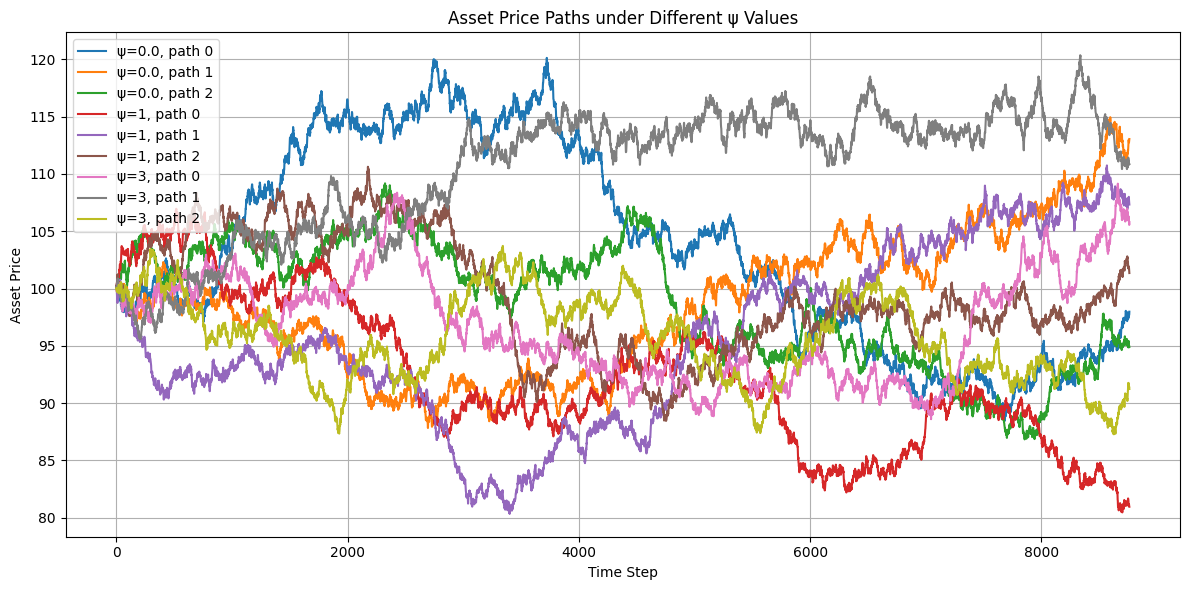

    time  path           S         delta        cash  portfolio_value
0      0     0  100.000000   -380.723809    0.000000    -3.807238e+04
1      0     1  100.000000   -380.723809    0.000000    -3.807238e+04
2      0     2  100.000000   -380.723809    0.000000    -3.807238e+04
3   2190     0  113.709361  26886.652780 -100.000000     3.057164e+06
4   2190     1   90.358560      0.682085  150.381976     2.120142e+02
5   2190     2  104.578787      0.682085    0.087097     7.141870e+01
6   4380     0  105.999953      0.682085  -99.911719    -2.761076e+01
7   4380     1   92.984791      0.682085  150.459418     2.138829e+02
8   4380     2  104.257114      0.682085    0.173927     7.128612e+01
9   6570     0   95.132624      0.682085  836.839882     9.017284e+02
10  6570     1  104.025163   9949.264096 -100.000000     1.034874e+06
11  6570     2   95.095542      0.682085    0.253127     6.511635e+01
12  8760     0   97.974491      0.682085  836.921479     9.037484e+02
13  8760     1  113.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import norm

# Simulation parameters
r = 0
mu = 0
S0 = 100
B0 = 1
sigma = 0.2
theta_0 = 1
b_0 = 0
b = -100
psi = 3  # change for comparison
dt = 1 / (365 * 24 * 1)  # hourly
beta = 0.28
alpha = 0.5
phi = 1
gamma = 0.2
zeta = 0.05
w0 = 10
T = 1  # total time in years
N = int(T / dt)
M = 3  # number of paths
quarter_len = int(0.25 / dt)  # 每季度步数
opex_indices = [0, quarter_len, 2 * quarter_len, 3 * quarter_len, N]

np.random.seed(42)

def bs_price(S, K, T, sigma, r=0, option_type='call'):
    if T <= 0 or sigma <= 0 or S <= 0 or K <= 0:
        return 0.0
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    if option_type == 'call':
        return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    else:
        return K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)

def bs_delta(S, K, T, sigma, option_type='call', r=0):
    if T <= 0 or sigma <= 0 or S <= 0 or K <= 0:
        return 0.0
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    if option_type == 'call':
        return norm.cdf(d1)
    else:
        return norm.cdf(d1) - 1

def simulate_full_paths(S0, b_0, sigma, psi, zeta, phi, theta_0, b,
                        dt, N, M, opex_indices, asset_type='SPX'):

    S = np.zeros((M, N + 1))
    b_t_I = np.zeros((M, N + 1))
    dDelta = np.zeros((M, N))
    M_t = np.zeros((M, N))
    delta_t = np.zeros((M, N + 1))

    K_call = np.zeros((M, len(opex_indices)))
    K_put = np.zeros((M, len(opex_indices)))

    S[:, 0] = S0
    b_t_I[:, 0] = b_0

    for path in range(M):
        for t in range(N + 1):
            if t == 0:
                T_remain = 0.25
                K_call[path, 0] = S0 * np.exp(sigma * np.sqrt(T_remain))
                K_put[path, 0] = S0 * np.exp(-sigma * np.sqrt(T_remain))
                put_price = bs_price(S=S0, K=K_put[path, 0], T=T_remain, sigma=sigma, option_type='put')
                call_price = bs_price(S=S0, K=K_call[path, 0], T=T_remain, sigma=sigma, option_type='call')
                delta_call = bs_delta(S0, K_call[path, 0], T_remain, sigma, 'call')
                delta_put = bs_delta(S0, K_put[path, 0], T_remain, sigma, 'put')
                theta = (b_0 - theta_0 * S0) / (put_price - call_price)
                theta_t = theta
                prev_delta = theta_0*1 + theta * (delta_put - delta_call)

            S_t = S[path, t - 1] if t > 0 else S0

            if t > 0:
                last_opex_t = max([i for i in opex_indices if i < t])  # 找 OE(t)
                u_range = np.arange(last_opex_t, t)
                exponent = np.exp(-phi * dt * (t - 1 - u_range))
                M_t[path, t - 1] = np.sum(exponent * dDelta[path, last_opex_t:t])

                dW = np.random.normal(0, np.sqrt(dt))
                S_t_safe = max(S_t, 1e-6)
                M_cap = np.clip(M_t[path, t - 1], -1e6, 1e6)
                feedback = psi * S_t * M_t[path, t - 1] * dt
                diffusion = sigma * S_t**(1 - zeta) * dW

                total_change = S_t + feedback + diffusion
                S[path, t] = max(min(total_change, 1e6), 1e-6)
                S_t = S[path, t]

            if t in opex_indices and t != 0:
                idx = opex_indices.index(t)
                call_payoff = theta_t * max(S_t - K_call[path, idx - 1], 0)
                put_payoff = theta_t * max(K_put[path, idx - 1] - S_t, 0)
                b_t = b_t_I[path, t - 1] - call_payoff + put_payoff

                T_remain = 0.25
                K_call[path, idx] = S_t * np.exp(sigma * np.sqrt(T_remain))
                K_put[path, idx] = S_t * np.exp(-sigma * np.sqrt(T_remain))

                delta_call = bs_delta(S_t, K_call[path, idx], T_remain, sigma, 'call')
                delta_put = bs_delta(S_t, K_put[path, idx], T_remain, sigma, 'put')
                call_price = bs_price(S=S_t, K=K_call[path, idx], T=T_remain, sigma=sigma, option_type='call')
                put_price = bs_price(S=S_t, K=K_put[path, idx], T=T_remain, sigma=sigma, option_type='put')

                if b_t - b >= theta_0 * (put_price - call_price):
                    dDelta[path, t - 1] = theta_0 * (1+ delta_put - delta_call) - prev_delta
                    prev_delta = theta_0 * (1+ delta_put - delta_call)
                    b_t_I[path, t] = b_t - theta_0 * (put_price - call_price)
                else:
                    theta = (b_t - b) / (put_price - call_price) if (put_price - call_price) != 0 else 0.0
                    dDelta[path, t - 1] = theta_0 *1 + theta * (delta_put - delta_call) - prev_delta
                    prev_delta = theta_0 *1 + theta * (delta_put - delta_call)
                    b_t_I[path, t] = b_t - theta * (put_price - call_price)
            elif t > 0:
                b_t_I[path, t] = b_t_I[path, t - 1]

            delta_t[path, t] = prev_delta

    return S, b_t_I, M_t, dDelta, delta_t

S_SPX, b_SPX, M_SPX, dDelta_SPX, delta_SPX = simulate_full_paths(
    S0, b_0, sigma, psi, zeta, phi, theta_0, b, dt, N, M, opex_indices, asset_type='SPX')



# 打印输出
for i in [S_SPX, b_SPX, M_SPX, dDelta_SPX, delta_SPX]:
    print(i)
def compare_psi_paths(psi_vals, seed=42):
    np.random.seed(seed)
    plt.figure(figsize=(12, 6))
    for psi_val in psi_vals:
        S_tmp, *_ = simulate_full_paths(
            S0, b_0, sigma, psi_val, zeta, phi, theta_0, b, dt, N, M, opex_indices
        )
        for path in range(M):
            plt.plot(S_tmp[path], label=f'ψ={psi_val}, path {path}')
    plt.title('Asset Price Paths under Different ψ Values')
    plt.xlabel('Time Step')
    plt.ylabel('Asset Price')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

compare_psi_paths(psi_vals=[0.0, 1, 3])



def simulate_full_paths(S0, b_0, sigma, psi, zeta, phi, theta_0, b,
                        dt, N, M, opex_indices, asset_type='SPX', seed=42):
    np.random.seed(seed)
    S = np.zeros((M, N + 1))
    b_t_I = np.zeros((M, N + 1))
    dDelta = np.zeros((M, N))
    M_t = np.zeros((M, N))
    delta_t = np.zeros((M, N + 1))
    portfolio_value = np.zeros((M, N + 1))

    K_call = np.zeros((M, len(opex_indices)))
    K_put = np.zeros((M, len(opex_indices)))

    S[:, 0] = S0
    b_t_I[:, 0] = b_0

    for path in range(M):
        for t in range(N + 1):
            if t == 0:
                T_remain = 0.25
                K_call[path, 0] = S0 * np.exp(sigma * np.sqrt(T_remain))
                K_put[path, 0] = S0 * np.exp(-sigma * np.sqrt(T_remain))
                put_price = bs_price(S=S0, K=K_put[path, 0], T=T_remain, sigma=sigma, option_type='put')
                call_price = bs_price(S=S0, K=K_call[path, 0], T=T_remain, sigma=sigma, option_type='call')
                delta_call = bs_delta(S0, K_call[path, 0], T_remain, sigma, 'call')
                delta_put = bs_delta(S0, K_put[path, 0], T_remain, sigma, 'put')
                theta = (b_0 - theta_0 * S0) / (put_price - call_price)
                theta_t = theta
                prev_delta = theta_0 *1 +theta * (delta_put - delta_call)

            S_t = S[path, t - 1] if t > 0 else S0

            if t > 0:
                last_opex_t = max([i for i in opex_indices if i < t])
                u_range = np.arange(last_opex_t, t)
                exponent = np.exp(-phi * dt * (t - 1 - u_range))
                M_t[path, t - 1] = np.sum(exponent * dDelta[path, last_opex_t:t])

                dW = np.random.normal(0, np.sqrt(dt))
                S_t_safe = max(S_t, 1e-6)
                feedback = psi * S_t * M_t[path, t - 1] * dt
                diffusion = sigma * S_t**(1 - zeta) * dW

                total_change = S_t + feedback + diffusion
                S[path, t] = max(min(total_change, 1e6), 1e-6)
                S_t = S[path, t]

            if t in opex_indices and t != 0:
                idx = opex_indices.index(t)
                call_payoff = theta_t * max(S_t - K_call[path, idx - 1], 0)
                put_payoff = theta_t * max(K_put[path, idx - 1] - S_t, 0)
                b_t = b_t_I[path, t - 1] - call_payoff + put_payoff

                T_remain = 0.25
                K_call[path, idx] = S_t * np.exp(sigma * np.sqrt(T_remain))
                K_put[path, idx] = S_t * np.exp(-sigma * np.sqrt(T_remain))

                delta_call = bs_delta(S_t, K_call[path, idx], T_remain, sigma, 'call')
                delta_put = bs_delta(S_t, K_put[path, idx], T_remain, sigma, 'put')
                call_price = bs_price(S=S_t, K=K_call[path, idx], T=T_remain, sigma=sigma, option_type='call')
                put_price = bs_price(S=S_t, K=K_put[path, idx], T=T_remain, sigma=sigma, option_type='put')

                if b_t - b >= theta_0 * (put_price - call_price):
                    dDelta[path, t - 1] = theta_0 * (1+delta_put - delta_call) - prev_delta
                    prev_delta = theta_0 * (1+ delta_put - delta_call)
                    b_t_I[path, t] = b_t - theta_0 * (put_price - call_price)
                else:
                    theta = (b_t - b) / (put_price - call_price) if (put_price - call_price) != 0 else 0.0
                    dDelta[path, t - 1] = theta_0 *1 +theta * (delta_put - delta_call) - prev_delta
                    prev_delta = theta * (1+ delta_put - delta_call)
                    b_t_I[path, t] = b_t - theta * (put_price - call_price)
            elif t > 0:
                b_t_I[path, t] = b_t_I[path, t - 1]

            delta_t[path, t] = prev_delta
            portfolio_value[path, t] = prev_delta * S_t + b_t_I[path, t]

    return {
        'S': S,
        'b': b_t_I,
        'M': M_t,
        'dDelta': dDelta,
        'delta': delta_t,
        'portfolio': portfolio_value
    }
# 提取每季度末的组合价值快照
def get_quarterly_summary(results, opex_indices):
    portfolio = results['portfolio']
    S = results['S']
    delta = results['delta']
    b = results['b']

    quarterly_summary = {
        'time': [],
        'path': [],
        'S': [],
        'delta': [],
        'cash': [],
        'portfolio_value': []
    }

    for t in opex_indices:
        for path in range(M):
            quarterly_summary['time'].append(t)
            quarterly_summary['path'].append(path)
            quarterly_summary['S'].append(S[path, t])
            quarterly_summary['delta'].append(delta[path, t])
            quarterly_summary['cash'].append(b[path, t])
            quarterly_summary['portfolio_value'].append(portfolio[path, t])

    df_summary = pd.DataFrame(quarterly_summary)
    return df_summary

# 用 ψ = 3 演示季度总结
results_psi3 = simulate_full_paths(
    S0, b_0, sigma, psi=3, zeta=zeta, phi=phi, theta_0=theta_0, b=b,
    dt=dt, N=N, M=M, opex_indices=opex_indices, seed=42
)
summary_df = get_quarterly_summary(results_psi3, opex_indices)
print(summary_df)

summary_df.to_csv('quarterly_summary_psi3.csv', index=False)


def compute_price_features(S, dt):
    M, T_len = S.shape
    realised_vol = []
    reversion = []
    sluggishness = []
    resistance = []

    for path in range(M):
        prices = S[path]
        log_returns = np.diff(np.log(prices))
        realised_vol.append(np.std(log_returns) * np.sqrt(1 / dt))  # annualised

        # Reversion: 1-lag autocorrelation of log returns
        if len(log_returns) > 1:
            autocorr = np.corrcoef(log_returns[:-1], log_returns[1:])[0, 1]
        else:
            autocorr = np.nan
        reversion.append(autocorr)

        # Sluggishness: 平均局部斜率变化（abs(ΔΔS)）
        dS = np.diff(prices)
        ddS = np.diff(dS)
        sluggishness.append(np.mean(np.abs(ddS)))

        # Resistance: 价格落入某小区间的时间比例（模拟为±2%区间）
        center = np.median(prices)
        lower = center * 0.98
        upper = center * 1.02
        time_in_band = np.sum((prices >= lower) & (prices <= upper)) / len(prices)
        resistance.append(time_in_band)

    return pd.DataFrame({
        'Path': list(range(M)),
        'Realised Vol': realised_vol,
        'Reversion (Autocorr)': reversion,
        'Sluggishness': sluggishness,
        'Resistance Level Ratio': resistance
    })

# 对 ψ = 3 的价格路径做特征分析
features_df = compute_price_features(results_psi3['S'], dt)
print(features_df)
